# Trying PC Algorithm

# Overview

To understand the PC Algorithm, analyzing relationships between features using a dataset from the UCI Machine Learning Repository.

Via conditional independence tests, progressively removes independent feature connections, in line with the PC Algorithm's approach.

 - [A survey of Bayesian Network structure learning](https://link.springer.com/article/10.1007/s10462-022-10351-w)

 - [An Algorithm for Fast Recovery of Sparse Causal Graphs](https://journals.sagepub.com/doi/abs/10.1177/089443939100900106)

 - [Estimating High-Dimensional Directed Acyclic Graphs with the PC-Algorithm](https://www.jmlr.org/papers/volume8/kalisch07a/kalisch07a.pdf)

 - [Renovamen/pcalg-py](https://github.com/Renovamen/pcalg-py)
 
 - [huawei-noah/trustworthyAI](https://github.com/huawei-noah/trustworthyAI)


## About PC Algorithm

Quote from "A survey of Bayesian Network structure learning - 3.2.2 The PC algorithm" :

> In the SGS algorithm, the adjacency phase tests "all possible conditioning sets for each pair of nodes", which is computationally expensive and involves many unreliable high-order Conditional Independence tests.
> 
> To address this, Spirtes and Glymour introduced the PC algorithm in 1991, which uses "incrementally" larger conditioning sets during the adjacency phase and "only considers nodes adjacent to each other".
> 
> Initially ineffective as PC starts with a complete graph, this method becomes beneficial by reducing the number and order of CI tests as edges are removed.

## PC Algorithm

## Algorithm 1: $PC_{pop}-algorithm$

![](PIC/pc_1.png)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from scipy import stats
from ucimlrepo import fetch_ucirepo
from copy import deepcopy
from utils import get_data_from_ucirepo

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/chunyuko/.cache/huggingface/token
Login successful


# Load Data from UCI Repository

 - [uci-ml-repo/ucimlrepo](https://github.com/uci-ml-repo/ucimlrepo)

 - [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

In [2]:
data = get_data_from_ucirepo(109)
label = data.columns.tolist()
data = data.to_numpy()

In [3]:
def plot_graph(graph, labels):
    """
    Plots a graph from a given adjacency matrix.

    :param graph: numpy array representing the adjacency matrix of the graph.
    :param l: list of labels for the nodes.
    """
    # Create a NetworkX graph from the adjacency matrix
    network = nx.from_numpy_array(graph)

    # Set up the layout for nodes in the graph
    pos = nx.spring_layout(network)


    # Draw the graph
    nx.draw(network, pos,
            edge_color="gray",  # Color of the edges
            width=1,            # Width of edges
            linewidths = 1,       # Width of the node border
            node_size = 600,      # Size of nodes
            font_size = 8,  # Size of the labels of nodes
            node_color="pink",  # Color of nodes
            alpha=0.9,          # Transparency of nodes
            labels=dict(zip(range(len(labels)), labels)))

In [4]:
def plot_heatmap(graph, labels):
    """
    Plots a heatmap of the graph adjacency matrix.

    :param graph: The adjacency matrix of the graph.
    :param labels: List of labels for the nodes.
    """
    fig, ax = plt.subplots()
    heatmap = ax.imshow(graph, cmap="binary")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if graph[i, j] == 1 and graph[j, i] == 1:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True))
                ax.add_patch(plt.Rectangle((i-0.5, j-0.5), 1, 1, fill=True))
                
    plt.show()

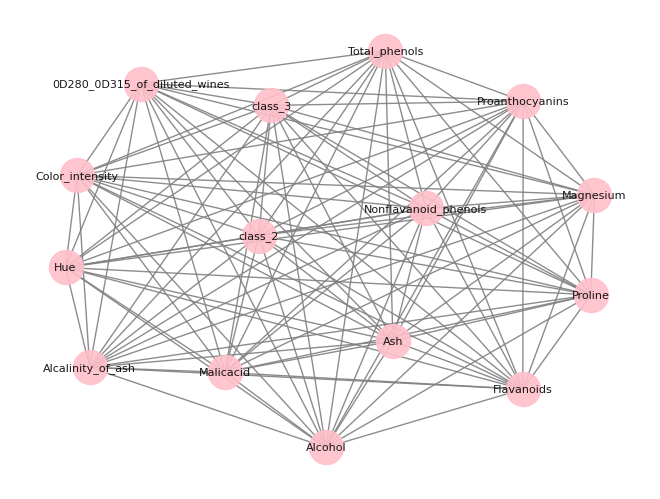

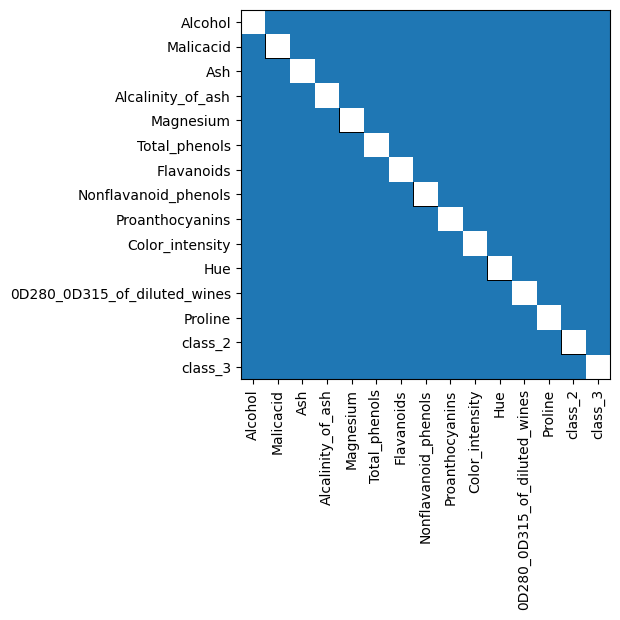

In [5]:
nodes = data.shape[1]
graph = np.ones((nodes, nodes)) - np.eye(nodes)

plot_graph(graph, label)
plot_heatmap(graph, label)

In [6]:
def is_independent(data, x, y, z):
    """
    Determines if variables x and y are independent given a set of controlling variables z.
    Uses partial correlation for this determination.
    Note: This function is directly copied from the "fisherz_test" function in 
    gcastle/castle/common/independence_tests.py available at:
    https://github.com/huawei-noah/trustworthyAI/blob/master/gcastle/castle/common/independence_tests.py
    
    :param data: numpy array of data
    :param x: index of the first variable
    :param y: index of the second variable
    :param z: list of indices of controlling variables
    :return: True if x and y are independent given z, False otherwise
    """
    
    n = data.shape[0]  # Number of observations
    k = len(z)  # Number of controlling variables

    # Calculate correlation or partial correlation based on the presence of controlling variables
    if k == 0:
        r = np.corrcoef(data[:, [x, y]].T)[0, 1]
    else:
        sub_index = [x, y] + list(z)
        sub_corr = np.corrcoef(data[:, sub_index].T)

        try:
            PM = np.linalg.inv(sub_corr)  # Precision matrix
        except np.linalg.LinAlgError:
            PM = np.linalg.pinv(sub_corr)  # Pseudo-inverse in case of singular matrix

        # Calculate the partial correlation
        r = -1 * PM[0, 1] / math.sqrt(abs(PM[0, 0] * PM[1, 1]))

    # Clip correlation to avoid numerical issues with extreme values
    cut_at = 0.99999
    r = min(cut_at, max(-1 * cut_at, r))

    # Compute the test statistic
    res = math.sqrt(n - k - 3) * 0.5 * math.log1p((2 * r) / (1 - r))
    p_value = 2 * (1 - stats.norm.cdf(abs(res)))

    # Determine independence based on the p-value
    return p_value >= 0.05


In [7]:
def pc_get_graph(data):
    """
    Implements the first phase of the PC algorithm to learn the structure of a graph.
    The function iteratively removes edges from a fully connected graph based on 
    conditional independence tests.

    :param data: numpy array of data, where each column represents a variable.
    :return: A tuple containing the adjacency matrix of the learned graph and 
             a dictionary of separated sets.
    """
    nodes = data.shape[1]  # Number of variables
    graph = np.ones((nodes, nodes)) - np.eye(nodes)  # Initialize a fully connected graph
    pairs = [*combinations(range(nodes), 2)]  # All possible pairs of variables

    subset_nodes = 0
    done = False
    separated_set = {}

    while not done and graph.any():
        done = True

        for x, y in pairs:
            if graph[x, y] == 1:
                # Get neighbors of x excluding y
                neighbors = [i for i in range(nodes) if graph[x, i] == 1 and i != y]

                if len(neighbors) >= subset_nodes:
                    done = False

                    for z in combinations(neighbors, subset_nodes):
                        z = list(z)  # Convert combination to list

                        if is_independent(data, x, y, z):
                            graph[x, y] = graph[y, x] = 0  # Remove edge between x and y
                            separated_set[(x, y)] = z
                            break

        subset_nodes += 1
    
    return graph, separated_set

In [8]:
graph, seperated_set = pc_get_graph(data)

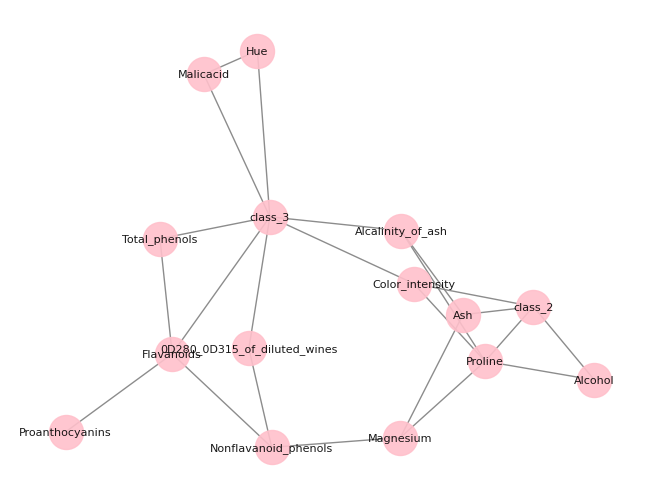

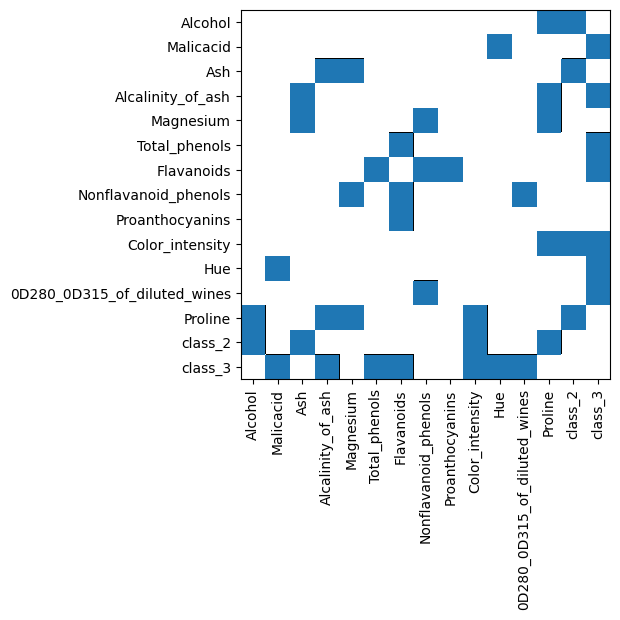

In [9]:
plot_graph(graph, label)
plot_heatmap(graph, label)

## Algorithm 2: Extending the skeleton to a CPDAG

![](PIC/pc_2.png)

### Rules

 - R1 Orient j −k into j → k whenever there is an arrow i → j such that i and k are nonadjacent.
 
 - R2 Orient i− j into i → j whenever there is a chain i → k → j.
 
 - R3 Orient i− j into i → j whenever there are two chains i−k → j and i−l → j such that k and l are nonadjacent.
 
 - R4 Orient i− j into i → j whenever there are two chains i−k → l and k → l → j such that k and l are nonadjacent.

In [10]:

def pc_apply_rules(graph, seperated_set):
    """
    Applies the PC algorithm rules to convert an undirected graph into a CPDAG.

    :param graph: The adjacency matrix of the undirected graph.
    :return: The adjacency matrix of the CPDAG.
    """
    
    graph_original = deepcopy(abs(graph))
    nodes = graph.shape[0]
    columns = list(range(nodes))
    
    for ij in seperated_set.keys():
        
        i, j = ij
        
        if graph_original[i, j] == 0 and graph_original[j, i] == 0:
            
            for k in [x for x in columns if x not in [i, j]]:
                
                if k not in seperated_set[ij]:
                    
                    if graph_original[i, k] == 1 and graph_original[k, i] == 1 \
                        and graph_original[j, k] == 1 and graph_original[k, j] == 1:
                        
                        graph_original[k, i] = 0
                        graph_original[k, j] = 0

    graph_final = deepcopy(graph_original)
    
    while True:
        change_made = False
        pairs = list(combinations(columns, 2))

        for i, j in pairs:
            
            # if direction in ij are not determined
            if graph_final[i, j] == 1 and graph_final[j, i] == 1:
                
                # all nodes that are not i or j
                for k in [x for x in columns if x not in [i, j]]:
                    
                    # R1
                    # Original: Orient j −k into j → k whenever there is an arrow i → j such that i and k are nonadjacent
                    #
                    # Here: Change "i - j" into "i → j" by removing "j → i"
                    #       if k → i and (k, j) are nonadjacent
                    
                    if graph_final[k, i] == 1 and graph_final[i, k] == 0 \
                        and graph_final[k, j] == 0:
                        graph_final[j, i] = 0
                        change_made = True
                    
                    # R2
                    # Original: Orient i− j into i → j whenever there is a chain i → k → j.
                    #
                    # Here: Change "i - j" into "i → j" by removing "j → i"
                    #       if i → k → j
                    
                    if graph_final[i, k] == 1 and graph_final[k, i] == 0 \
                        and graph_final[k, j] == 1 and graph_final[j, k] == 0:
                        graph_final[j, i] = 0
                        change_made = True
                
                for k in [x for x in columns if x not in [i, j]]:
                    for l in [x for x in columns if x not in [i, j, k]]:
                        
                        # R3
                        # Original: Orient i− j into i → j whenever there are two chains i−k → j and i−l → j such that k and l are nonadjacent.
                        #
                        # Here: Change "i - j" into "i → j" by removing "j → i"
                        #       if "i − k → j" and "i − l → j" and (k, l) are nonadjacent
                        
                        if graph_final[i, k] == 1 and graph_final[k, i] == 1 \
                            and graph_final[k, j] == 1 and graph_final[j, k] == 0 \
                            and graph_final[i, l] == 1 and graph_final[l, i] == 1 \
                            and graph_final[l, j] == 1 and graph_final[j, l] == 0 \
                            and graph_final[k, l] == 0 and graph_final[l, k] == 0:
                            graph_final[j, i] = 0
                            change_made = True
                        
                        # R4
                        # Original: Orient i− j into i → j whenever there are two chains i−k → l and k → l → j such that k and l are nonadjacent.
                        #
                        # Here: Change "i - j" into "i → j" by removing "j → i"
                        #       if "i - k → l" and "k → l → j" and (k, l) are nonadjacent
                        if graph_final[i, k] == 1 and graph_final[k, i] == 1 \
                            and graph_final[k, l] == 1 and graph_final[l, k] == 0 \
                            and graph_final[l, j] == 1 and graph_final[j, l] == 0 \
                            and graph_final[k, l] == 0 and graph_final[l, k] == 0:
                            graph_final[j, i] = 0
                            change_made = True

        if not change_made:
            break

    return graph_final

In [11]:
final_graph = pc_apply_rules(graph, seperated_set)

R1
R1
R1
R1
R2


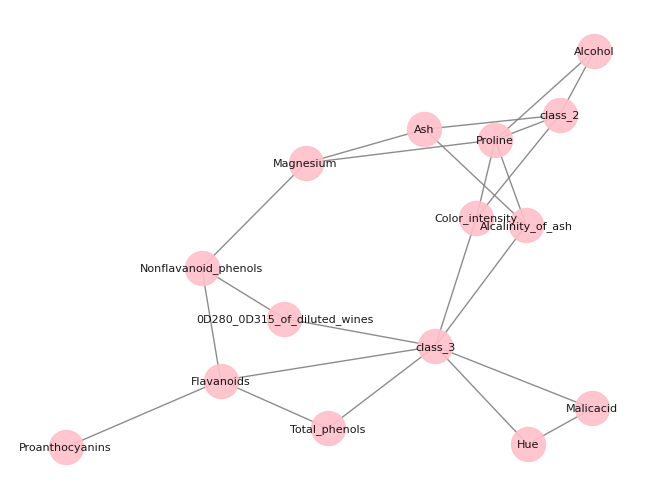

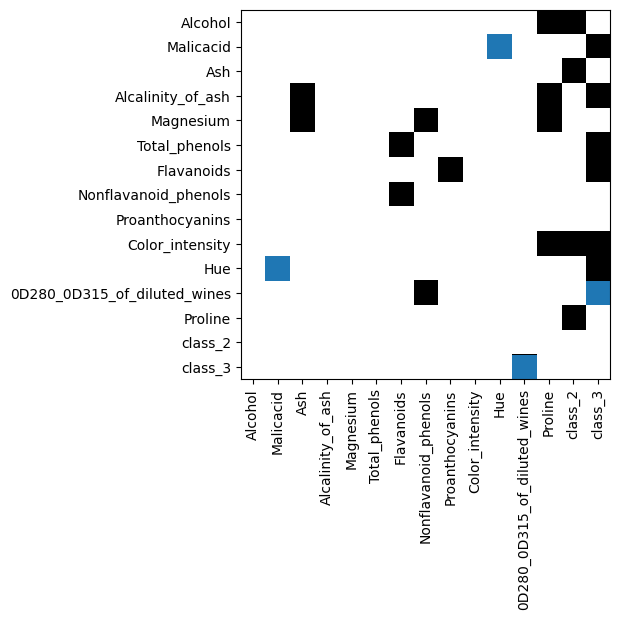

In [12]:
plot_graph(final_graph, label)
plot_heatmap(final_graph, label)